# **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# **Check and display dataset files**

**Four Total Classes**

1. move backward
2. move forward
3. rotate left
4. rotate right

**1.5 seconds per sample, 400 samples per class**

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/robot-operation-dataset/metadata.csv
/kaggle/input/robot-operation-dataset/backward/backward_270.wav
/kaggle/input/robot-operation-dataset/backward/backward_56.wav
/kaggle/input/robot-operation-dataset/backward/backward_147.wav
/kaggle/input/robot-operation-dataset/backward/backward_38.wav
/kaggle/input/robot-operation-dataset/backward/backward_49.wav
/kaggle/input/robot-operation-dataset/backward/backward_132.wav
/kaggle/input/robot-operation-dataset/backward/backward_160.wav
/kaggle/input/robot-operation-dataset/backward/backward_18.wav
/kaggle/input/robot-operation-dataset/backward/backward_17.wav
/kaggle/input/robot-operation-dataset/backward/backward_67.wav
/kaggle/input/robot-operation-dataset/backward/backward_210.wav
/kaggle/input/robot-operation-dataset/backward/backward_63.wav
/kaggle/input/robot-operation-dataset/backward/backward_278.wav
/kaggle/input/robot-operation-dataset/backward/backward_372.wav
/kaggle/input/robot-operation-dataset/backward/backward_99.w

# **Play an audio sample to ensure proper loading**

In [3]:
import IPython.display as ipd
filepath = "/kaggle/input/robot-operation-dataset/backward/backward_0.wav"
filepath2 = "/kaggle/input/robot-operation-dataset/forward/forward_0.wav"

ipd.Audio(filepath)

# **Plot waveforms and spectrograms of audio samples**

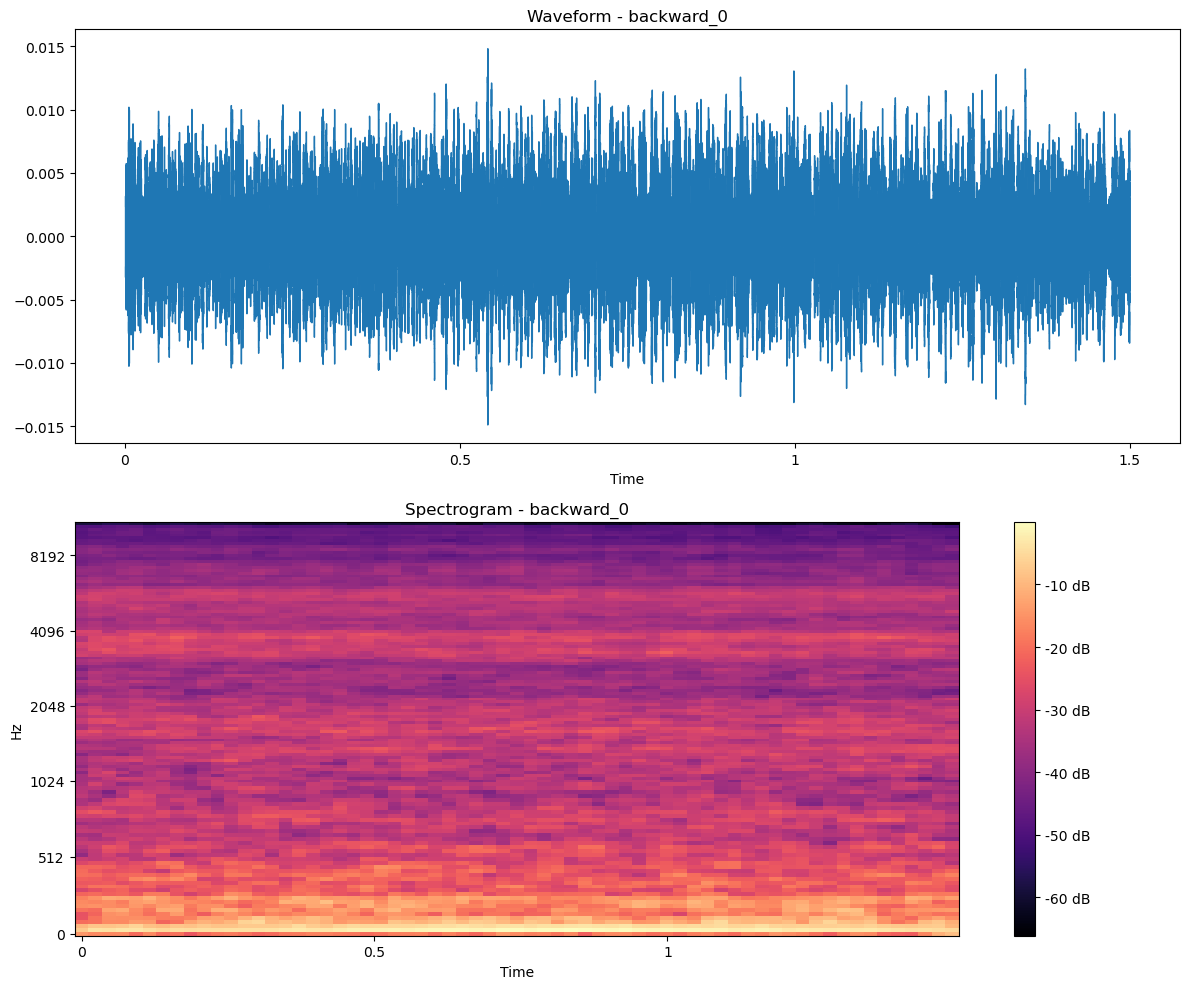

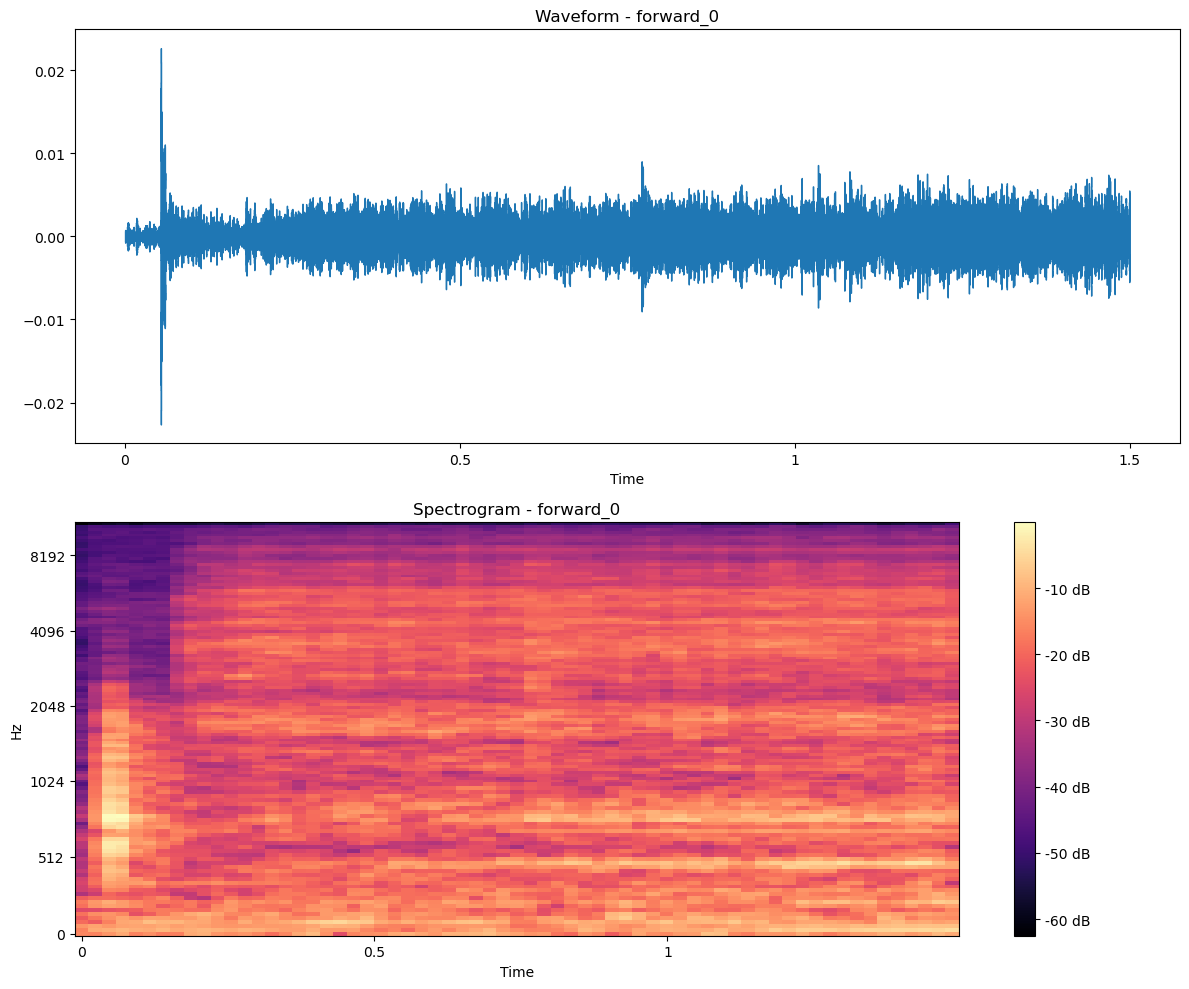

In [4]:
import librosa
import librosa.display

# Load and plot the waveform and spectrogram for backward_0
data, sample_rate = librosa.load(filepath)
plt.figure(figsize=(12, 10))

# Plot waveform
plt.subplot(2, 1, 1)
librosa.display.waveshow(data, sr=sample_rate)
plt.title('Waveform - backward_0')

# Plot spectrogram
plt.subplot(2, 1, 2)
spectrogram = librosa.feature.melspectrogram(y=data, sr=sample_rate)
librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram - backward_0')

plt.tight_layout()
plt.show()

# # Load and plot the waveform and spectrogram for forward_0
data, sample_rate = librosa.load(filepath2)
plt.figure(figsize=(12, 10))

# Plot waveform
plt.subplot(2, 1, 1)
librosa.display.waveshow(data, sr=sample_rate)
plt.title('Waveform - forward_0')

# Plot spectrogram
plt.subplot(2, 1, 2)
spectrogram = librosa.feature.melspectrogram(y=data, sr=sample_rate)
librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram - forward_0')

plt.tight_layout()
plt.show()

# **Create & save spectrogram for each file**

In [5]:
# Define input and output directories
input_dir = "/kaggle/input/robot-operation-dataset"
output_dir = "/kaggle/working/"

In [6]:
# Define target classes
classes = ['backward', 'forward', 'left', 'right']

# Create and store spectrogram for each audio file
for class_name in classes:
    class_input_dir = os.path.join(input_dir, class_name)
    class_output_dir = os.path.join(output_dir, "spectrograms", class_name)
    os.makedirs(class_output_dir, exist_ok=True)
    
    for filename in os.listdir(class_input_dir):
        if filename.endswith('.wav'):
            # Load audio file
            file_path = os.path.join(class_input_dir, filename)
            audio, sr = librosa.load(file_path)

            # Compute spectrogram
            spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
            spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

            # Plot and save the spectrogram as an image
            output_path = os.path.join(class_output_dir, f'{os.path.splitext(filename)[0]}.png')
            plt.figure(figsize=(8, 4))
            librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
            plt.savefig(output_path)
            plt.close()

# **Import saved spectrograms as dataset**

In [7]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 4

# Make a dataset containing the training spectrograms
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(output_dir, 'spectrograms'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=0)

# Make a dataset containing the validation spectrogram
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(output_dir, 'spectrograms'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=0)


class_names = train_dataset.class_names
print("\nClasses:")
for i, class_name in enumerate(class_names):
    print(f"Class {i}: {class_name}")

Found 1600 files belonging to 4 classes.
Using 1280 files for training.
Found 1600 files belonging to 4 classes.
Using 320 files for validation.

Classes:
Class 0: backward
Class 1: forward
Class 2: left
Class 3: right


# **Preprocess dataset**

In [8]:
# Split train_dataset into X_train and y_train
X_train = []
y_train = []
for images, labels in train_dataset:
    X_train.append(images)
    y_train.append(labels)
X_train = tf.concat(X_train, axis=0)
y_train = tf.concat(y_train, axis=0)

# Split valid_dataset into X_test and y_test
X_test = []
y_test = []
for images, labels in valid_dataset:
    X_test.append(images)
    y_test.append(labels)
X_test = tf.concat(X_test, axis=0)
y_test = tf.concat(y_test, axis=0)

In [9]:
# Normalize feature variables
X_train = X_train / 255.0
X_test = X_test/ 255.0

# One hot encode class variables
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [10]:
# Check shape of all variables
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1280, 256, 256, 3)
Shape of y_train: (1280, 4)
Shape of X_test: (320, 256, 256, 3)
Shape of y_test: (320, 4)


# **Audio Classification Model Creation**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 activation_1 (Activation)   (None, 128, 128, 64)      0

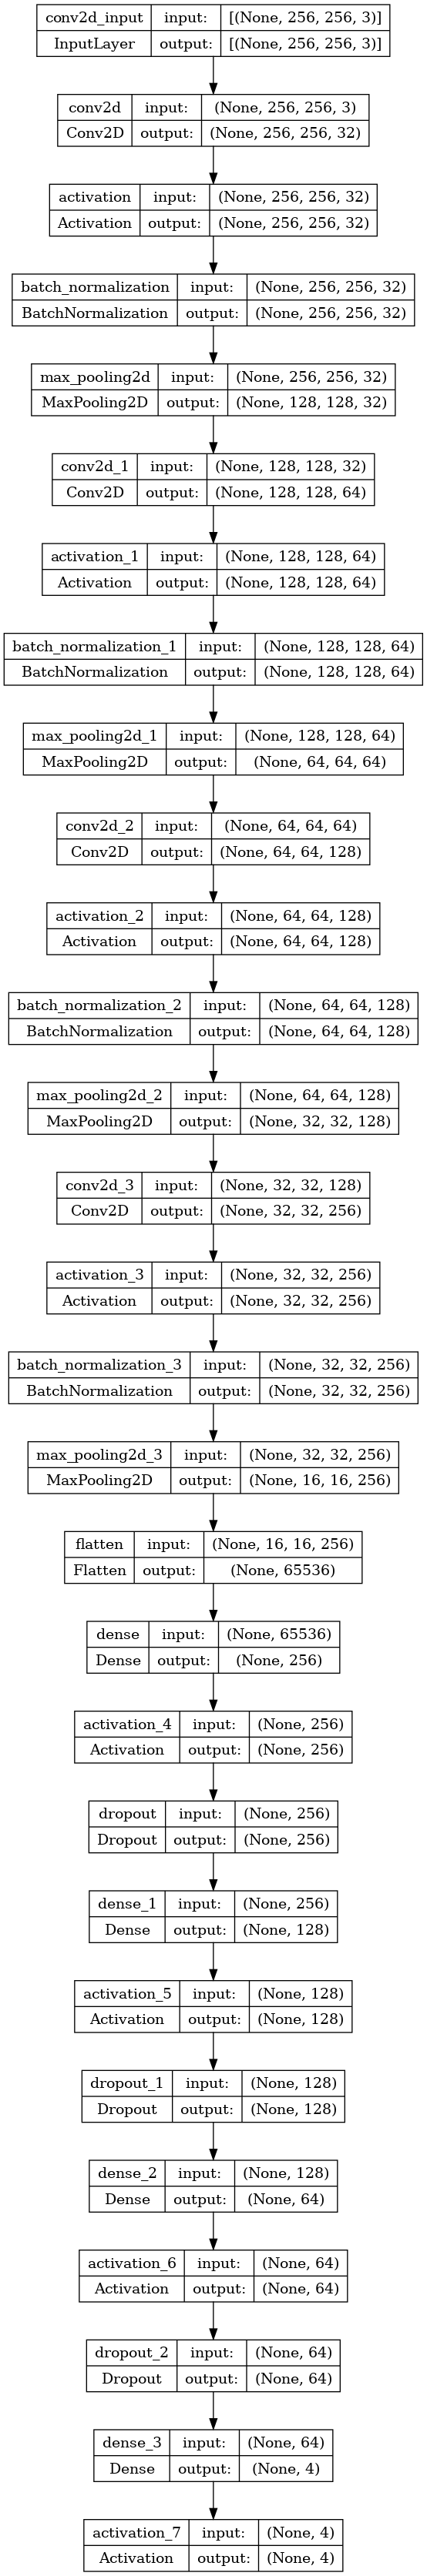

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Set up model parameters
epochs = 20
dropout = .2

# Define CNN model
model=Sequential()

# First layer
model.add(Conv2D(32,(3,3), padding='same', input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

# Second layer
model.add(Conv2D(64,(3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

# Third layer
model.add(Conv2D(128,(3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

# Fourth layer
model.add(Conv2D(256,(3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

# Flatten layer
model.add(Flatten())

# Dense layer 1
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(dropout))
#model.add(BatchNormalization())

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(dropout))
#model.add(BatchNormalization())

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(dropout))
#model.add(BatchNormalization())

model.add(Dense(4))
model.add(Activation('softmax'))


# View model summary
model.summary()

# Plot model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# **Compile the model**

In [12]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

# **Train and evaluate the model**

In [13]:
history = model.fit(X_train, y_train, epochs = epochs, verbose = 1, validation_data = (X_test, y_test))

Epoch 1/20
40/40 [==============================] - 15s 74ms/step - loss: 6.7109 - accuracy: 0.4852 - val_loss: 2.7098 - val_accuracy: 0.4500
Epoch 2/20
40/40 [==============================] - 2s 61ms/step - loss: 1.6458 - accuracy: 0.6836 - val_loss: 0.8766 - val_accuracy: 0.5625
Epoch 3/20
40/40 [==============================] - 2s 62ms/step - loss: 0.5114 - accuracy: 0.8406 - val_loss: 1.5974 - val_accuracy: 0.2688
Epoch 4/20
40/40 [==============================] - 3s 63ms/step - loss: 0.2979 - accuracy: 0.8930 - val_loss: 1.8416 - val_accuracy: 0.2844
Epoch 5/20
40/40 [==============================] - 2s 62ms/step - loss: 0.2438 - accuracy: 0.9000 - val_loss: 1.1914 - val_accuracy: 0.4688
Epoch 6/20
40/40 [==============================] - 2s 61ms/step - loss: 0.1531 - accuracy: 0.9305 - val_loss: 0.6208 - val_accuracy: 0.8188
Epoch 7/20
40/40 [==============================] - 3s 63ms/step - loss: 0.1431 - accuracy: 0.9461 - val_loss: 0.4142 - val_accuracy: 0.9031
Epoch 8/20
4

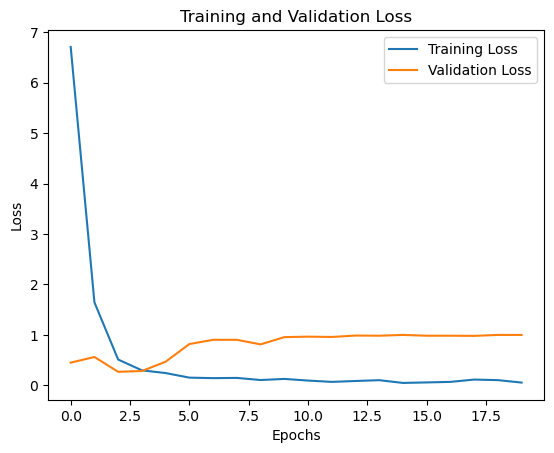

In [14]:
# Plot the loss on training and validation data
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_accuracy'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

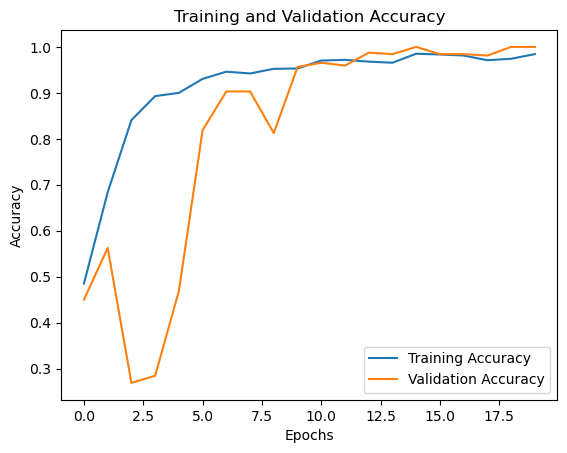

In [15]:
# Plot the accuracy on training and validation data
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Check test accuracy and statistics**

In [16]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

1.0


In [17]:
#model.predict_classes(X_test)
predict=model.predict(X_test) 
classes_x=np.argmax(predict,axis=1)
print(classes_x)

10/10 [==============================] - 0s 21ms/step
[1 1 2 3 2 3 0 2 3 2 0 3 2 2 1 2 3 1 1 0 1 1 1 0 0 2 3 0 2 0 2 3 3 3 2 2 0
 0 2 3 2 1 2 2 0 3 1 2 3 0 0 3 0 2 3 2 2 1 1 3 3 0 2 0 2 2 0 1 2 3 0 1 2 2
 3 1 2 3 1 3 0 1 0 3 2 3 0 2 3 3 1 2 3 3 0 1 1 0 1 3 2 3 1 2 1 1 2 1 3 3 0
 2 0 0 2 3 2 1 2 1 0 0 0 2 1 2 1 2 0 1 0 0 2 2 0 0 0 3 1 0 3 1 3 1 0 0 2 1
 2 2 1 1 0 0 0 2 0 2 1 3 1 2 2 0 2 3 1 0 3 0 2 0 2 1 3 3 2 3 0 3 3 3 1 0 0
 1 0 2 1 0 1 0 1 2 3 3 3 1 2 0 1 1 3 1 0 0 0 1 0 3 2 3 0 1 1 2 2 0 2 0 1 2
 1 0 1 3 2 3 3 0 0 3 1 2 3 2 1 2 0 2 3 3 2 2 0 3 1 2 1 1 0 0 1 3 1 0 1 0 0
 1 3 2 3 3 1 3 0 0 3 2 0 2 1 0 3 2 3 0 0 0 2 2 2 0 3 1 2 2 0 0 2 0 0 3 3 0
 2 1 1 1 3 2 2 1 2 2 1 3 0 1 0 3 3 0 3 0 1 2 2 1]


In [18]:
predict.shape

(320, 4)

In [19]:
y_test.shape

(320, 4)

In [20]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report
# accuracy: (tp + tn) / (p + n)

y_predict=np.argmax(predict, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_predict)
print(cm)
print('\n\nClassification Report : \n\n',classification_report(y_test,y_predict))
accuracy = accuracy_score(y_test,y_predict)
print('Accuracy: %f' % accuracy)

[[86  0  0  0]
 [ 0 75  0  0]
 [ 0  0 86  0]
 [ 0  0  0 73]]


Classification Report : 

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        86
           1       1.00      1.00      1.00        75
           2       1.00      1.00      1.00        86
           3       1.00      1.00      1.00        73

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320

Accuracy: 1.000000


# **Test audio sample**

In [21]:
from PIL import Image

# Preprocess the image
image_path = '/kaggle/working/spectrograms/right/right_123.png'
image_size = (256, 256)

image = Image.open(image_path)
image = image.convert('RGB')
image = image.resize(image_size)
image = np.array(image) / 255.0

# Reshape the image to match the model's input shape
input_image = np.expand_dims(image, axis=0)

# Reshape the image to match the model's input shape
input_image = np.expand_dims(image, axis=0)

# Make a prediction
predictions = model.predict(input_image)

# Interpret the prediction
predicted_class = np.argmax(predictions[0])
predicted_class_name = class_names[predicted_class]

print(f"Predicted class: {predicted_class}")
print(f"Predicted class name: {predicted_class_name}")

1/1 [==============================] - 0s 207ms/step
Predicted class: 3
Predicted class name: right
